In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torch.utils.data import Dataset
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import models, transforms
from torchvision.models.segmentation import DeepLabV3_ResNet50_Weights
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from newloader import Crack_loader
from pathlib import Path

c:\Users\skoka3\.conda\envs\ooga\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data_test_path = r'C:\Users\skoka3\Desktop\CIVE-FP\test_train_valid\test'

DIR_IMG_test = os.path.join(data_test_path, 'images')
DIR_MASK_test = os.path.join(data_test_path, 'masks')

In [3]:
img_names_test = [path.name for path in Path(DIR_IMG_test).glob('*.jpg')]
mask_names_test= [path.name for path in Path(DIR_MASK_test).glob('*.png')]

test_dataset = Crack_loader(img_dir=DIR_IMG_test, img_fnames=img_names_test, mask_dir=DIR_MASK_test,
                              mask_fnames=mask_names_test, isTrain=True)

## Mount the drive

## Loading the Coarse damage dataset

## Load data

## Train the model

## Color map function

In [4]:
# Define your color map
color_map = {
    0: [0, 0, 0],          # No - black
    1: [128, 128, 128],    # Shadows - grey
    2: [218, 165, 32],     # Dirt - goldenrod
    3: [0, 255, 127],      # Vegetative Growth - springgreen
    4: [255, 0, 255],      # Debris - fuchsia
    5: [128, 0, 128],      # Marks - purple
    6: [255, 99, 71],      # Spalling - tomato
    7: [255, 255, 0]       # Voids - yellow
}

# Function to apply color mapping to an image
def apply_color_map(image, color_map):
    height, width = image.shape
    color_mask = np.zeros((height, width, 3), dtype=np.uint8)
    for key, color in color_map.items():
        indices = image == key
        color_mask[indices] = color
    return color_mask

In [5]:
# Define the IoU calculation function
def calculate_iou(predicted_mask, ground_truth_mask, num_classes):
    predicted_mask = torch.argmax(predicted_mask, dim=1)
    iou_list = []
    for cls in range(num_classes):
        pred_inds = predicted_mask == cls
        target_inds = ground_truth_mask == cls
        intersection = pred_inds[target_inds].sum()
        union = pred_inds.sum() + target_inds.sum() - intersection
        if union == 0:
            iou = float('nan')  # Exclude from evaluation if no ground truth
        else:
            iou = float(intersection) / float(max(union, 1))
        iou_list.append(iou)
    return np.nanmean(iou_list)  # Return the mean IoU value for this image
 


In [6]:
from model.TransMUNet import TransMUNet
num_classes = 8
# model = TransMUNet()
Net = TransMUNet(n_classes=num_classes)
saved_model = 'finetuned_Crackformer_final.pth'
Net.load_state_dict(torch.load(saved_model, map_location='cpu')['model_weights'])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
Net.eval()


TransMUNet(
  (down_blocks): ModuleList(
    (0): ResidualBlock(
      (hdc): Sequential(
        (0): ConvBlock(
          (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU()
        )
        (1): ConvBlock(
          (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2))
          (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU()
        )
        (2): ConvBlock(
          (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(5, 5), dilation=(5, 5))
          (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU()
        )
      )
      (shortcut): Sequential(
        (0): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum

In [7]:
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, drop_last=True)

In [8]:
def calculate_iou(predicted_mask, ground_truth_mask, num_classes):
    iou_list = []
    for cls in range(num_classes):
        iou_per_batch = []
        for batch in range(predicted_mask.shape[0]):  # Loop over each image in the batch
            pred_inds = (predicted_mask[batch] == cls)
            target_inds = (ground_truth_mask[batch] == cls)
            intersection = (pred_inds & target_inds).sum()
            union = pred_inds.sum() + target_inds.sum() - intersection
            if union == 0:
                iou = float('nan')  # Exclude from evaluation if no ground truth
            else:
                iou = float(intersection) / float(max(union, 1))
            iou_per_batch.append(iou)
        iou_list.append(np.nanmean(iou_per_batch))  # Average over the batch

    return np.nanmean(iou_list)  # Average over all classes


C:\Users\skoka3\AppData\Local\Temp\ipykernel_52076\1855657601.py:15: RuntimeWarning: Mean of empty slice
  iou_list.append(np.nanmean(iou_per_batch))  # Average over the batch


Average Test mIoU: 0.2938


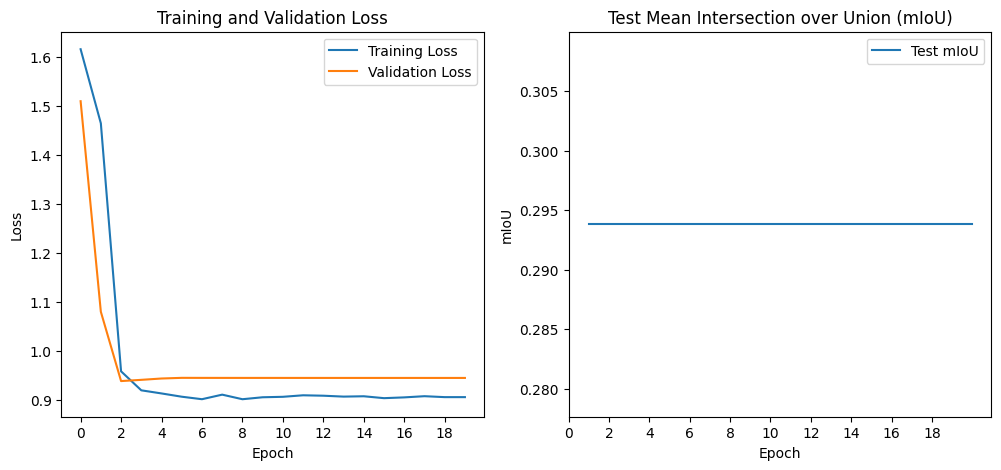

In [9]:
from newloader import Crack_loader  # Replace with your actual dataset module
import matplotlib.pyplot as plt


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the trained model
model_path = 'finetuned_Crackformer_final.pth'
Net = TransMUNet(n_classes=8) # Replace with your actual model class
Net.load_state_dict(torch.load(model_path, map_location=device)['model_weights'])
Net.eval()
Net.to(device)

# Load test dataset
data_test_path = r'C:\Users\skoka3\Desktop\CIVE-FP\test_train_valid\test'
DIR_IMG_test = os.path.join(data_test_path, 'images')
DIR_MASK_test = os.path.join(data_test_path, 'masks')

img_names_test = [path.name for path in Path(DIR_IMG_test).glob('*.jpg')]
mask_names_test = [path.name for path in Path(DIR_MASK_test).glob('*.png')]

test_dataset = Crack_loader(img_dir=DIR_IMG_test, img_fnames=img_names_test, mask_dir=DIR_MASK_test, mask_fnames=mask_names_test, resize=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Calculate Test mIoU
test_miou_total = 0.0
for batch in test_loader:
    img = batch['image'].to(device, dtype=torch.float32)
    true_mask = batch['mask'].to(device, dtype=torch.long)
    with torch.no_grad():
        output = Net(img)
        pred_mask = torch.argmax(output, dim=1)
    test_miou = calculate_iou(pred_mask, true_mask, num_classes)  # Use your num_classes
    test_miou_total += test_miou

avg_test_miou = test_miou_total / len(test_loader)
print(f'Average Test mIoU: {avg_test_miou:.4f}')

# Load training and validation loss data
train_losses = np.load('train_losses.npy')
val_losses = np.load('val_losses.npy')
epochs = len(train_losses)  # Assuming number of epochs is equal to the length of train_losses


plt.figure(figsize=(12, 5))

# Training and Validation Loss Plot
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.xticks(np.arange(0, epochs, 2))  # Set x-axis ticks for every 2 epochs

# Test mIoU Plot
plt.subplot(1, 2, 2)
plt.plot(np.arange(1, epochs + 1), [avg_test_miou] * epochs, label='Test mIoU')
plt.title('Test Mean Intersection over Union (mIoU)')
plt.xlabel('Epoch')
plt.ylabel('mIoU')
plt.legend()
plt.xticks(np.arange(0, epochs, 2))  # Set x-axis ticks for every 2 epochs

plt.show()